# Protein Fragmentation and Analysis
This notebook demonstrates how to use the AlphaFragment library to process individual proteins, or a CSV file containing data on multiple proteins, including how to identify domains, fragment proteins, plot domain and fragment locations, and save the output.

## Processing a single protein
### Step 1: Initialising protein as a protein object
Proteins are dealt with as `Protein` class objects (defined in the `classes` module).
They are defined with a name (which can be anything and does not have to match the name on UniProt), UniProt accession id, and sequence

In [1]:
from alphafragment.classes import Protein

# Define the sequence of Ana1
ana1_sequence = 'MALQLTVNGKFGANLRRTIGPLDDPEQVRKDLESERRITRLKQVREKSNHLARQIREDVAAEKRRQIHKLEQVKQRELNAWREHVLVKKHQDYRSAIFQVGAAHRAAKEENERIEQQRQERIDKIRRCRKQALKRSAKASVELRTTNTMNLNAEGRASAGTQTPIVEDKENRMESGCNKPCCKGKRKRKTSCGCASTDAEDEKEDDASSDDDSSILIIESPSSNRRLQKTTPVILDVEIEETISETDKNPEGMDINDRFMQTNRKFSHVVRPSDDEPQRRPRFTQISDLVRKTETTVRAGPSQRREADPTPPVSAPPSPTKSPPRSPRKCVEREEPVPAPAPRKSPTKTAKGSPKKTVTAPRNQPSVKRTGLKLNPAPAKVIDAGIHRGQKAKAPATLPKVTAIQKPAVEPPRNLPPIPEQAMPAVPNPSMTHCYPMPQNQPYMHPYAQLPMQPYAMPYSMPFPVQAQFPQPHPMYAPQQMMPNQPAVLGPAITAPPSTATQSTVSTTTITMSSRQDPRTTQCGRVQFYDHSNKYHRTYEAPTQSVQCNEKDATQLTAMDHARIENQLRDLREQELDKLRKISDDRGQKALEREQVRRDCAELTEKLDALTQQQPQLLPTDANIIPSHRYADAAARREQKMNDAMEEMLLRPAIITCPEVRTKPTPPNLSRSKSKASVAVNLGEPPVQIGRDNLGSSESCSSILLDYVNDQSKQLKSDLQAEQSNSLKSMRLKSLLERIEKIRVQLLEELKAGESGASKGDNAQELNNIRQERADILSERTRTLNERESDLQQKEAILEQRLRKFYKETKNAKSSESDKPKSNAKEDGPVEIIIKVRSDGTVKQYVPRTKSKAKTKPSAIDNEKDVPLGSTDSTPRDDEPKPTEQDHGKRPFLQDQRQISIDSNSTAYRSLPPVSYKNMTTAAPPSAPLHPMVVQYINRLLGMTRQNIDEMGVSSSCVTTPSTSVINSLRNVTPCPEPEAGRAERDQDENTEMNEHRMERVQTFIADNRSLINDLEESIRCQQQLQREQQSLDAEKSMRAFDQIWNKRLAKNPEDCQQTNKEKEQTREKMPRERPTPQGDRKNAAPPQESGKIRRTQEGDRQQQTNGAVQQKREQKTVKQGSGADKSTNRFAPEKSKALSTSEESSARNMERYAQLTENCTQRIAELTELITKVREEKQRLVEVTLTSNSDGERQSTEYLELPTGQQQTRCRTISDRSDSQTPSTSEALPLQKHKPTAASRDSGIADSRPITAQGQVCIDVEPISLGSSTQNNTARGRVRAPPATIRRYSPQLNAEDLAHELSTITEVETPGQSHIVAATPVPKPFPSFDQYAKELHLDLSRLDADQSQRLQGEFNDLILAIRQRNQGTDYREFPSINAYLHNMTSTRIHVEIGQDADQATLSPGELMRQLRVITHSIQDFPKRREYFEKLMAKQPPDQRDLIDSASLENDSTDSFNVEEELRQRKILKNSFRRGNATETTLTAQEVASSTRRESVAPVTNDQPNESGIDPLSGSNFSSDADQRSPCWHATMHERQQQVDELCSSTTASSPERRPRKSRLRGGHEHNNRSKDDSTVQDASQIGRSLNLREFLTRELLKHRVHDDVASESSDESLRGHFLKSVLHSLSPSNNTQTPGVGVSHATGATNDRQKTSTPVGSFLSIPEKAGSMSNTGSQLFSGESRISLVNYPDGTPPIPFEQQSKLSTNQTRQSSGQIGSGVRTTHRKSPRK'

# Initialize Ana1 as a Protein object
ana1 = Protein(name="Ana1", accession_id="Q9VC64", sequence=ana1_sequence)

print(ana1)
print(ana1.sequence)

Protein Name: Ana1, Accession ID: Q9VC64, Domains: 0, Fragments: 0
MALQLTVNGKFGANLRRTIGPLDDPEQVRKDLESERRITRLKQVREKSNHLARQIREDVAAEKRRQIHKLEQVKQRELNAWREHVLVKKHQDYRSAIFQVGAAHRAAKEENERIEQQRQERIDKIRRCRKQALKRSAKASVELRTTNTMNLNAEGRASAGTQTPIVEDKENRMESGCNKPCCKGKRKRKTSCGCASTDAEDEKEDDASSDDDSSILIIESPSSNRRLQKTTPVILDVEIEETISETDKNPEGMDINDRFMQTNRKFSHVVRPSDDEPQRRPRFTQISDLVRKTETTVRAGPSQRREADPTPPVSAPPSPTKSPPRSPRKCVEREEPVPAPAPRKSPTKTAKGSPKKTVTAPRNQPSVKRTGLKLNPAPAKVIDAGIHRGQKAKAPATLPKVTAIQKPAVEPPRNLPPIPEQAMPAVPNPSMTHCYPMPQNQPYMHPYAQLPMQPYAMPYSMPFPVQAQFPQPHPMYAPQQMMPNQPAVLGPAITAPPSTATQSTVSTTTITMSSRQDPRTTQCGRVQFYDHSNKYHRTYEAPTQSVQCNEKDATQLTAMDHARIENQLRDLREQELDKLRKISDDRGQKALEREQVRRDCAELTEKLDALTQQQPQLLPTDANIIPSHRYADAAARREQKMNDAMEEMLLRPAIITCPEVRTKPTPPNLSRSKSKASVAVNLGEPPVQIGRDNLGSSESCSSILLDYVNDQSKQLKSDLQAEQSNSLKSMRLKSLLERIEKIRVQLLEELKAGESGASKGDNAQELNNIRQERADILSERTRTLNERESDLQQKEAILEQRLRKFYKETKNAKSSESDKPKSNAKEDGPVEIIIKVRSDGTVKQYVPRTKSKAKTKPSAIDNEKDVPLGSTDSTPRDDEPKPTEQDHGKRPFLQDQRQISIDSNSTAYRSLPPVSYKNMTTAAPPSAPLHPMV

To avoid having to manually find and and define sequences, this can instead be found using the protein accession id, using the `fetch_uniprot_info` function from the `uniprot_fetch` module

In [2]:

from alphafragment.classes import Protein
from alphafragment.uniprot_fetch import fetch_uniprot_info

# Fetch information for Ana1 protein using its UniProt ID
ana1_data = fetch_uniprot_info("Q9VC64")

# Extract the sequence from the fetched data
sequence = ana1_data.get('sequence', '')

# Initialize Ana1 as a Protein object
ana1 = Protein(name="Ana1", accession_id="Q9VC64", sequence=sequence)

print(ana1)
print(ana1.sequence)

Protein Name: Ana1, Accession ID: Q9VC64, Domains: 0, Fragments: 0
MALQLTVNGKFGANLRRTIGPLDDPEQVRKDLESERRITRLKQVREKSNHLARQIREDVAAEKRRQIHKLEQVKQRELNAWREHVLVKKHQDYRSAIFQVGAAHRAAKEENERIEQQRQERIDKIRRCRKQALKRSAKASVELRTTNTMNLNAEGRASAGTQTPIVEDKENRMESGCNKPCCKGKRKRKTSCGCASTDAEDEKEDDASSDDDSSILIIESPSSNRRLQKTTPVILDVEIEETISETDKNPEGMDINDRFMQTNRKFSHVVRPSDDEPQRRPRFTQISDLVRKTETTVRAGPSQRREADPTPPVSAPPSPTKSPPRSPRKCVEREEPVPAPAPRKSPTKTAKGSPKKTVTAPRNQPSVKRTGLKLNPAPAKVIDAGIHRGQKAKAPATLPKVTAIQKPAVEPPRNLPPIPEQAMPAVPNPSMTHCYPMPQNQPYMHPYAQLPMQPYAMPYSMPFPVQAQFPQPHPMYAPQQMMPNQPAVLGPAITAPPSTATQSTVSTTTITMSSRQDPRTTQCGRVQFYDHSNKYHRTYEAPTQSVQCNEKDATQLTAMDHARIENQLRDLREQELDKLRKISDDRGQKALEREQVRRDCAELTEKLDALTQQQPQLLPTDANIIPSHRYADAAARREQKMNDAMEEMLLRPAIITCPEVRTKPTPPNLSRSKSKASVAVNLGEPPVQIGRDNLGSSESCSSILLDYVNDQSKQLKSDLQAEQSNSLKSMRLKSLLERIEKIRVQLLEELKAGESGASKGDNAQELNNIRQERADILSERTRTLNERESDLQQKEAILEQRLRKFYKETKNAKSSESDKPKSNAKEDGPVEIIIKVRSDGTVKQYVPRTKSKAKTKPSAIDNEKDVPLGSTDSTPRDDEPKPTEQDHGKRPFLQDQRQISIDSNSTAYRSLPPVSYKNMTTAAPPSAPLHPMV

### Step 2: Finding domains in a protein
Domains can be identified using various sources:

- **UniProt**: Contains data on domain locations and types, but may often miss domains or not have them formatted ideally for fragmentation.
- **AlphaFold Database (AFDB)**: Predicted structures can be used as another source of structural domain information. The UniProt accession id is used to access these from the AFDB. AFDB is useful for finding structural domains but cannot label domain types or find non structural functional domains.
- **Manual specification**: Used to specify domains when the other sources are not sufficient. Discussed in more detail later.

It is typically best to use both AFDB and UniProt to get structural and functional/annotated information. The `compile_domains` function can be used to find all the domains in a protein using specified sources.

Domains are stored as domain objects, which have:
- A descriptive ID
- Start and end coordinates in the protein (0-indexed)
- A 'type' indicating where the domain was found

In [3]:
from alphafragment.domain_compilation import compile_domains

# Compile domains for Ana1
uniprot_alphafold_domains = compile_domains(ana1, uniprot=True, alphafold=True, manual=False)

17 domains found in AlphaFold structure for Ana1: [Domain(id=AF_D1, start=23, end=136, domain_type='AF'), Domain(id=AF_D2, start=554, end=615, domain_type='AF'), Domain(id=AF_D3, start=625, end=651, domain_type='AF'), Domain(id=AF_D4, start=699, end=722, domain_type='AF'), Domain(id=AF_D5, start=724, end=752, domain_type='AF'), Domain(id=AF_D6, start=761, end=812, domain_type='AF'), Domain(id=AF_D7, start=927, end=951, domain_type='AF'), Domain(id=AF_D8, start=988, end=1050, domain_type='AF'), Domain(id=AF_D9, start=1141, end=1186, domain_type='AF'), Domain(id=AF_D10, start=1323, end=1366, domain_type='AF'), Domain(id=AF_D11, start=1373, end=1386, domain_type='AF'), Domain(id=AF_D12, start=1401, end=1412, domain_type='AF'), Domain(id=AF_D13, start=1419, end=1435, domain_type='AF'), Domain(id=AF_D14, start=1455, end=1467, domain_type='AF'), Domain(id=AF_D15, start=1586, end=1600, domain_type='AF'), Domain(id=AF_D16, start=1611, end=1627, domain_type='AF'), Domain(id=AF_D17, start=1723, 

**Manual specification** of domain locations and labels can be useful:
- As a main source of domain information for proteins with no accession id

- For specifying known regions of interest that are not listed in uniprot and will not be found in alphafold

- For labelling sites of interest eg phosphorylation sites (single residue domains like this will not affect fragmentation but will be marked on output plots which can be useful)

Manual domains are specified as a dataframe with the `protein_data` argument, and are expected to use 1 based indexing

In [5]:
import pandas as pd

# using made up domains as example
domains = [("Interacts_with_Sas4", (10, 50)), ("Plk4_phosphorylation_site", (150, 150))]
domains_df = pd.DataFrame({
    'name': ['Ana1'],
    'domains': [str(domains)]
})

# Compile domains for Ana1 including manual domains
manual_domains = compile_domains(ana1, uniprot=False, alphafold=False, manual=True, protein_data=domains_df)
print(manual_domains)

2 domains found in csv for Ana1: [Domain(id=Interacts_with_Sas4, start=9, end=49, domain_type='manually_defined'), Domain(id=Plk4_phosphorylation_site, start=149, end=149, domain_type='manually_defined')]
[Domain(id=Interacts_with_Sas4, start=9, end=49, domain_type='manually_defined'), Domain(id=Plk4_phosphorylation_site, start=149, end=149, domain_type='manually_defined')]


This is designed to work with a list of proteins and domains in a csv, so is not be the easiest way to add manual domains for a single protein.

Instead, it may be more straightforward to define domain objects and add these to the protein directly.

However, this does require domains to be specifed using 0 based indexing rather than 1 based as before (the compile domains function internally converts indices), and for the domain_type to be specified as "manually_defined" (plotting function may have unexpected output if this is different).

In [6]:
from alphafragment.classes import Domain

# Example of manually specifying domains
manual_domains = [
    Domain(identifier="Interacts_with_Sas4", start=9, end=49, domain_type="manually_defined"),
    Domain(identifier="Plk4_phosphorylation_site", start=149, end=149, domain_type="manually_defined")
]

print(manual_domains)

[Domain(id=Interacts_with_Sas4, start=9, end=49, domain_type='manually_defined'), Domain(id=Plk4_phosphorylation_site, start=149, end=149, domain_type='manually_defined')]


When using the `compile_domains` function, all domain sources (uniprot, alphafold and manual) are set to `True` by default. UniProt and AFDB will be skipped if no or invalid accession id is associated with the protein, and manual skipped if no domain data is provided

### Step 4: Adding domains to protein object

Rather than adding domains directly to the protein object, compile_domains will return a list of domain objects. These then have to be associated with the protein object.

Protein objects have an `add_domain` function, which adds a single domain to the `domain_list` attribute of the protein object. This means all domains associated with a protein can be easily accessed from that protein object.

In [7]:
# Add uniprot and alphafold domains to the protein object
for domain in uniprot_alphafold_domains:
    ana1.add_domain(domain)

# Add manually specified domains to the protein object
for domain in manual_domains:
    ana1.add_domain(domain)

# Print the updated domain list of Ana1
print(ana1.domain_list)

[Domain(id=AF_D1, start=23, end=136, domain_type='AF'), Domain(id=AF_D2, start=554, end=615, domain_type='AF'), Domain(id=AF_D3, start=625, end=651, domain_type='AF'), Domain(id=AF_D4, start=699, end=722, domain_type='AF'), Domain(id=AF_D5, start=724, end=752, domain_type='AF'), Domain(id=AF_D6, start=761, end=812, domain_type='AF'), Domain(id=AF_D7, start=927, end=951, domain_type='AF'), Domain(id=AF_D8, start=988, end=1050, domain_type='AF'), Domain(id=AF_D9, start=1141, end=1186, domain_type='AF'), Domain(id=AF_D10, start=1323, end=1366, domain_type='AF'), Domain(id=AF_D11, start=1373, end=1386, domain_type='AF'), Domain(id=AF_D12, start=1401, end=1412, domain_type='AF'), Domain(id=AF_D13, start=1419, end=1435, domain_type='AF'), Domain(id=AF_D14, start=1455, end=1467, domain_type='AF'), Domain(id=AF_D15, start=1586, end=1600, domain_type='AF'), Domain(id=AF_D16, start=1611, end=1627, domain_type='AF'), Domain(id=AF_D17, start=1723, end=1728, domain_type='AF'), Domain(id=Disordered,

### Step 5: Protein fragmentation

The main function of AlphaFragment is the fragmentation of proteins within set parameters. The `fragment_protein` function is used for this. This function can be run by inputting the protein object, and once complete the protein length and fragments chosen fragments will be printed


In [8]:
from alphafragment.fragment_protein import fragment_protein

# Fragment the protein
fragments = fragment_protein(ana1)

Ana1  is  1729  residues long and has  6 fragments : [(0, 391), (371, 755), (724, 967), (927, 1307), (1277, 1477), (1447, 1729)]


The function uses several parameters which can be customised by arguments

- **Minimum**, **maximum** and **ideal** fragment `length`. To find a solution, lengths from **ideal** to **max**, and then **ideal** to **min** will be tested until an accetable solution is found. The **ideal** value can be anywhere between the **min** and **max**. These parameters will be used as guidelines and are generally adhered to, but there are a few exceptions. If domains are longer than the maximum set **length**, they will be kept intact giving a longer fragment.
- To increase the chance of creating fragments in which all interaction sites are intact, fragments overlap. Like fragment **length**, the size of overlaps can also be dictated by giving **minimum**, **maximum** and **ideal** values for the `overlap` parameter.
- `length` and `overlap` are specified as dictonaries, with keys for **min**, **ideal** and **max**. The default is `length = {'min': 150, 'ideal': 384, 'max': 400}` and `overlap = {'min': 20, 'ideal': 30, 'max': 40}`
- If an acceptable solution cannot be found within the given **length** and **overlap** restrictions, the **max length** is increased incrementally by an amount specified by the parameter `len_increase`. The default value for this is 10.
- The fragmentation process is recursive, and for long proteins the recursion depth means processing time increases exponentially. To avoid this, a timer is used so that after a set amount of tuime trying to fragment, thae protein wll be broken roughly in half (still avoiding cutting through domains), and fragmentation tried agin on each half. The time limit can be atered with the `time_limit` argument. However, only long proteins will be affected by this, and the default value should work well, so his should not need to be changed. The default value is 0.1 (seconds).

The fragments generated are then added to the protein object using the `add_fragment` method. This allows easy access to all fragments associated with a protein.



In [9]:
from alphafragment.fragment_protein import fragment_protein

# Fragment the protein with specified parameters
length = {'min': 150, 'ideal': 384, 'max': 400}
overlap = {'min': 20, 'ideal': 30, 'max': 40}
len_increase = 10
time_limit = 0.1
fragments = fragment_protein(ana1, length, overlap, len_increase, time_limit)

Ana1  is  1729  residues long and has  6 fragments : [(0, 391), (371, 755), (724, 967), (927, 1311), (1281, 1477), (1447, 1729)]


### Step 6: Adding Fragments to the Protein Object

After fragmenting the protein, the generated fragments need to be added to the protein object. This step ensures that all fragments are associated with the protein and can be accessed easily for further analysis or visualization. Fragments must be added in order, which helps to prevent any accidental duplication - note that this means that running this cell multiple tmes will gave a Value Error.

In [10]:
# Add fragments to protein object
for fragment in fragments:
    ana1.add_fragment(fragment)

print(ana1.fragment_list)

[(0, 391), (371, 755), (724, 967), (927, 1311), (1281, 1477), (1447, 1729)]


### Step 7: Plotting domains and fragments

The function `plot_fragmentation_output` plots the protein sequence length on the x axis, with domains protein as large coloured bars, and fragments as horizontal red bars. The aim for this is both to enable verifification of the domain finding and fragmentation of the protein, and to create a reference map of the protein that can be useful later for interpretting predictions.

![Fragmentation Plot](fragment_plot.png)

Necessary arguments for this are the `protein` object, and a list of the `fragments` (which can be found with `protein.fragment_list`).

As default, the domains will be coloured by their id, but this can be changed by the `color_mode` argument. The options for this are
- `type`: default, colours by id
- `origin`: colours by domains source (eg UniProt, AlphaFold)
- `cycle`: uses a cycle of colours to give differentiation between nearby domains of the same class

Domains are also by default labelled if they are from UniProt or manually defined - AFDB identified domains are not labelled as their labels are not meaningful. This can be changed with the `label` argument.

A location to save images can be specified as a string with the argument `save_location`, and the figure size changed with the figsize argument (default = (12, 4))

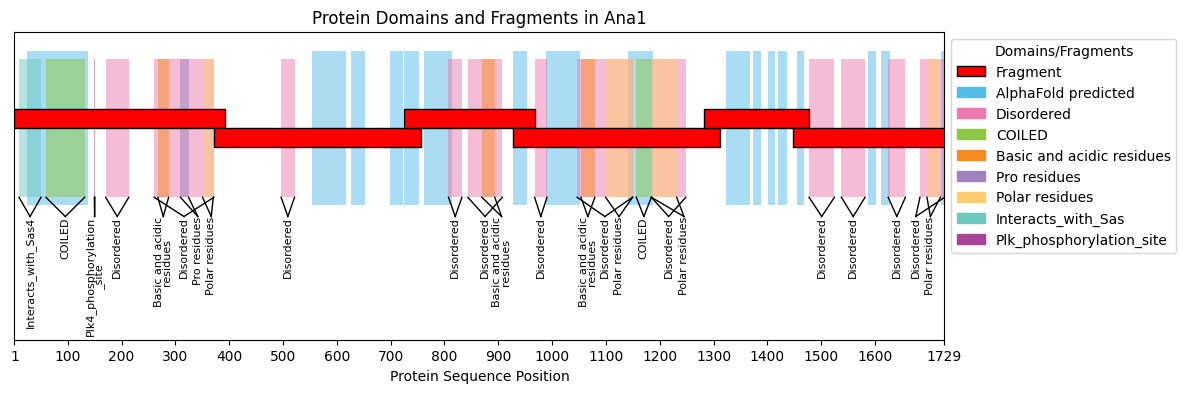

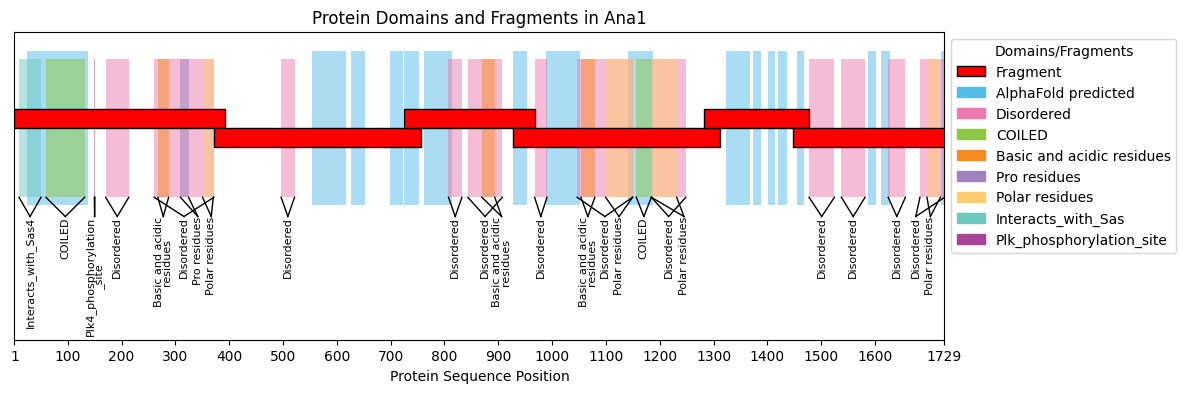

In [11]:
from alphafragment.plot_fragments import plot_fragmentation_output

# Plot the fragmentation output
plot_fragmentation_output(protein=ana1, fragments=ana1.fragment_list, color_mode='type')

# Color fragments based on their origin
#plot_fragmentation_output(protein=ana1, fragments=ana1.fragment_list, color_mode='origin')

# Color fragments randomly
#plot_fragmentation_output(protein=ana1, fragments=ana1.fragment_list, color_mode='cycle')

## Processing multiple proteins from a csv file

### CSV file format

The CSV file must have columns `name` and `accession_id`
| name      | accession_id |
|-----------|--------------|

Each protein should be one row of the table, and must have a **name** and either an **accession_id** OR a **sequence** in a column `sequence`. **Names** must be unique for all proteins, but do not need to match the name corresponding to that accession_id on UniProt
| name      | accession_id | sequence    |
|-----------|--------------|-------------|
| Protein1  | Q9VC64       |             |
| Protein2  |              | ACFRNDIEN   |

If both a valid **accession_id** and a **sequence** are given for a protein, the provided **sequence** will be overridden by the sequence found on UniProt for that **accession_id**.
| name      | accession_id | sequence            |
|-----------|--------------|---------------------|
| Protein1  | Q9VC64       |                     |
| Protein2  |              | ACFRNDIEN           |
| Protein3  | O76074       | WILL_BE_OVERWRITTEN |

Manually specified domains can be added in a column `domains`. These must be 1 indexed and either a:
- **list of (start, end) tuples** if domains are not labelled, eg [(D1_first_res, D1_last_res), (D2_first_res, D2_last_res)]
- **list of (id, (start, end)) tuples** if domains are labelled, eg [("D1_label", (D1_first_res, D1_last_res)), ("D2_label", (D2_first_res, D2_last_res))]

| name      | accession_id | sequence    | domains                                           |
|-----------|--------------|-------------|---------------------------------------------------|
| Protein1  | Q9VC64       |             | [("active_site", (10, 50)), ("p150", (150, 150))] |
| Protein2  | P12345       |             | [(5, 25), (30, 60), (85, 97)]                     |

Other columns can also be included. These can be named anything, and will be mostly ignored in processing, but included in the output file if the results of domain identification and fragmentation are saved as a csv (covered later)
| name      | accession_id | sequence    | domains                                           | other_cols |
|-----------|--------------|-------------|---------------------------------------------------|------------|
| Protein1  | Q9VC64       |             | [("active_site", (10, 50)), ("p150", (150, 150))] | other      |

Column order is not important . Capitalization will be ignored for all columns, and any spaces in column names replaced with '_'. so that
| dOmAIns | accession ID | col 1 | Name   | SEQUENCE  | COl_2 |
|---------|--------------|-------|--------|-----------|-------|

will be processed the same as
| name   | accession_id | sequence  | domains | col_1 | col_2 |
|--------|--------------|-----------|---------|-------|-------|

### Step 1: Reading in protein data

The `initialize_proteins_from_csv` function loads a CSV file set out in this way into a list of **Protein** objects and a **DataFrame** containing all data from the CSV.

In [12]:
from alphafragment.process_proteins_csv import initialize_proteins_from_csv

input_csv_path = 'sample_data/usage_guide_sample.csv'

# import protein data from a csv file into a list of Protein objects and a dataframe of all data in the csv
proteins, df = initialize_proteins_from_csv(input_csv_path)

Successfully initialized proteins: ['Ana1', 'CycB3', 'CP110', 'Msps', 'Asp', 'AurB']


In the case of proteins failing to be read in, this will be indicated by a final print statement

>Proteins with errors or no data available: {proteins_with_errors}

Which lists all failed proteins. Other print statements are for extra information and can be ignored.

### Step 2: Finding domains, fragmenting proteins and plotting outputs

Domain finding, fragmentation and plotting is carried out by looping through the proteins and processing each individually exactly as before

Here we do not have any manual domains to specify so this is set to False for domain finding. Leaving this as True is fine but will lead to some unnecesary print statements letting you know that no manual domains/domains column can be found.


17 domains found in AlphaFold structure for Ana1: [Domain(id=AF_D1, start=23, end=136, domain_type='AF'), Domain(id=AF_D2, start=554, end=615, domain_type='AF'), Domain(id=AF_D3, start=625, end=651, domain_type='AF'), Domain(id=AF_D4, start=699, end=722, domain_type='AF'), Domain(id=AF_D5, start=724, end=752, domain_type='AF'), Domain(id=AF_D6, start=761, end=812, domain_type='AF'), Domain(id=AF_D7, start=927, end=951, domain_type='AF'), Domain(id=AF_D8, start=988, end=1050, domain_type='AF'), Domain(id=AF_D9, start=1141, end=1186, domain_type='AF'), Domain(id=AF_D10, start=1323, end=1366, domain_type='AF'), Domain(id=AF_D11, start=1373, end=1386, domain_type='AF'), Domain(id=AF_D12, start=1401, end=1412, domain_type='AF'), Domain(id=AF_D13, start=1419, end=1435, domain_type='AF'), Domain(id=AF_D14, start=1455, end=1467, domain_type='AF'), Domain(id=AF_D15, start=1586, end=1600, domain_type='AF'), Domain(id=AF_D16, start=1611, end=1627, domain_type='AF'), Domain(id=AF_D17, start=1723, 

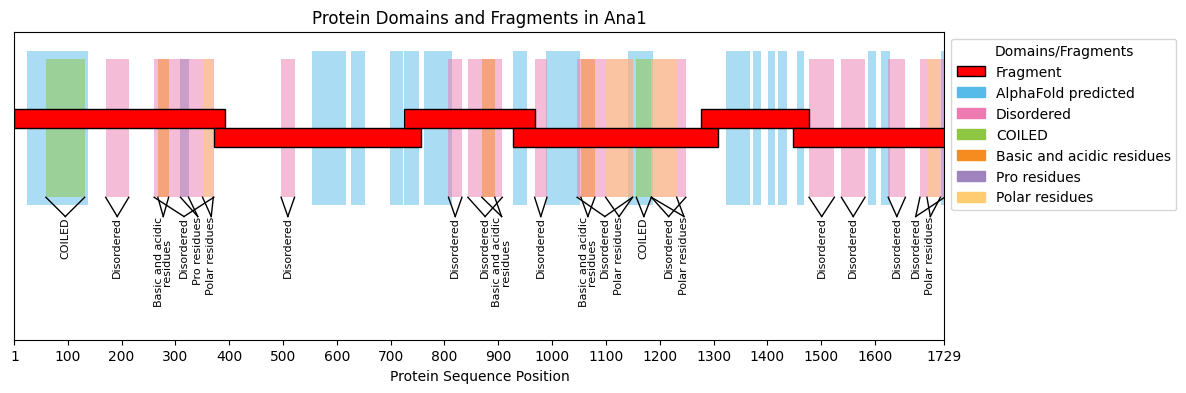

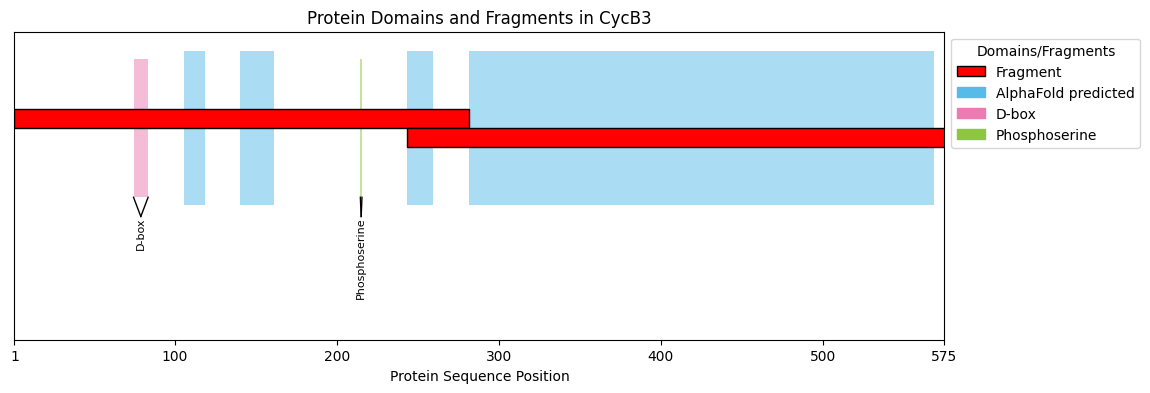

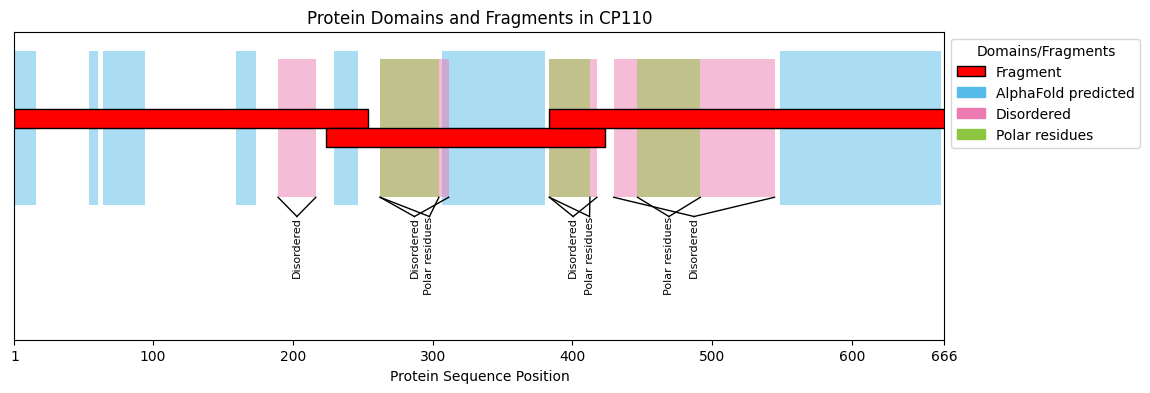

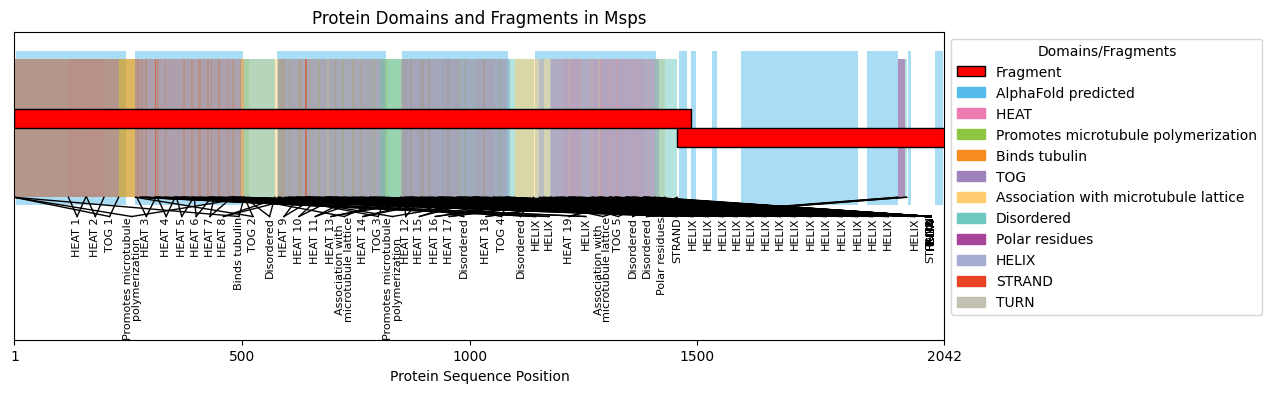

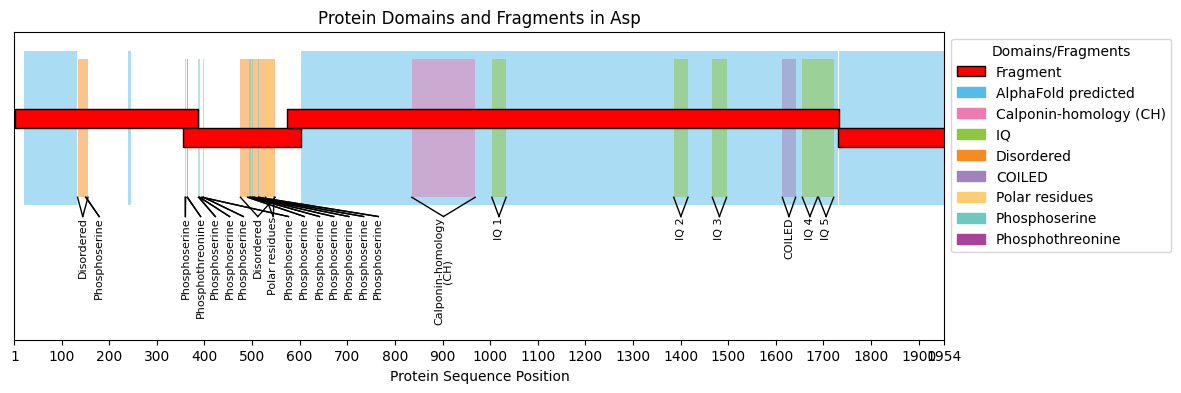

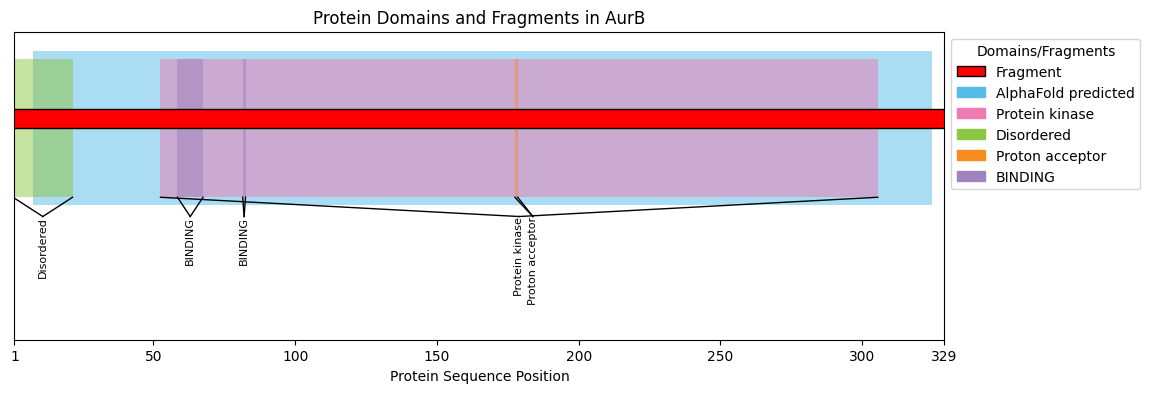

In [13]:
from alphafragment.domain_compilation import compile_domains
from alphafragment.fragment_protein import fragment_protein
from alphafragment.plot_fragments import plot_fragmentation_output

for protein in proteins:
    # identify domains
    domains = compile_domains(protein, protein_data=df, manual=False)
    # add domains to protein object
    for domain in domains:
        protein.add_domain(domain)

    # fragment the protein
    fragments = fragment_protein(protein)
    # add fragments to protein object
    for fragment in fragments:
        protein.add_fragment(fragment)

    # create graphic of domain locations and fragmentation results
    plot_fragmentation_output(protein, fragments)

    # uncomment this to save images to a specific location (here a folder 'fragmentation_images/' in the current directory)
    #image_save_location = 'fragmentation_images/'
    #plot_fragmentation_output(protein, fragments, image_save_location)

### Step 3: refining domain and fragment identification

Looking at these plots, most proteins have been successfully fragmented, but Msps and Asp both have concerningly long fragments. In Msps, this seems to be due to the large number of domains found in UniProt, with disordered regions categorised as domains between every pair of structured domains. In Asp, this is due to a very large domain that has been found in the AlphaFold structre.

For both of these, better fragmentation may be possible by manually refining the domains found in UniProt and AlphaFold. This can be achieved in the csv file while leaving the rest of the proteins unchanged, by leaving out the accession_ids for Msps and Asp, and instead providing sequence and domains manually.

To keep some domains that have been found in UniProt/AlphaFold, the identified domains list can be found in the domain finding print statements or the domain_list associated with that protein - however, remember that these will be 0 indexed, while manually specified domains are expected to be 1 indexed. To get a 1 indexed list of domains for each protein, skip to Step 4 to save all protein data to a csv.

| Name    | Accession_id | Length | Sequence | Category | Domains |
|---------|--------------|--------|----------|----------|---------|
| Msps    |              | 2042   | MAEDTEYKKLPVEERCVHKLWKARV... | PCM core | [("binds_tubulin",(1,496)), ("TOG_1",(1,229)), ("TOG_2",(267,496)), ("functionally_important",(497,515)), ("promotes_microtubule_polymerisation",(516,1080)), ("TOG_3",(581,814)), ("TOG_4",(849,1087)), ("association_with_microtubule_lattice",(1099,1428)), ("TOG_5",(1179,1415)), ("helix1",(1461,1472)), ("helix2",(1488,1496)), ("helix3",(1515,1518)), ("helix4",(1534,1549)), ("helix5",(1590,1593)), ("TOG_6",(1599,1852)), ("helix6",(1875,1906)), ("helix7",(1903,1941)), ("polar_residues",(1940,1960)), ("helix8",(1960,1971)), ("helix9",(2022,2042))] |
| Asp     |              | 1954   | MSAFEITVTPSRLKQKKRAEGREPA... | PCM core | [("structured", (24, 128)), ("conserved", (460, 474)), ("conserved", (513, 523)), ("structured", (586, 997)), ("conserved", (460, 474)), ("conserved", (513, 523)), ("conserved", (1082, 1103)), ("conserved", (1209, 1232)), ("conserved", (1410, 1417)), ("conserved", (1495, 1529)), ("conserved", (1611, 1616)), ("conserved", (1626, 1653)), ("helix", (1678, 1709)), ("helix", (1713, 1728)), ("structured", (1735, 1949))] |

Rerunning the previous code with these changes in the csv file, and enabling manual domain finding, should improve the fragmentation

No valid accession ID provided. Skipping UniProt fetch operation.
UniProt fetch failed for Msps; using manually provided sequence.
No valid accession ID provided. Skipping UniProt fetch operation.
UniProt fetch failed for Asp; using manually provided sequence.
Successfully initialized proteins: ['Ana1', 'CycB3', 'CP110', 'Msps', 'Asp', 'AurB']
17 domains found in AlphaFold structure for Ana1: [Domain(id=AF_D1, start=23, end=136, domain_type='AF'), Domain(id=AF_D2, start=554, end=615, domain_type='AF'), Domain(id=AF_D3, start=625, end=651, domain_type='AF'), Domain(id=AF_D4, start=699, end=722, domain_type='AF'), Domain(id=AF_D5, start=724, end=752, domain_type='AF'), Domain(id=AF_D6, start=761, end=812, domain_type='AF'), Domain(id=AF_D7, start=927, end=951, domain_type='AF'), Domain(id=AF_D8, start=988, end=1050, domain_type='AF'), Domain(id=AF_D9, start=1141, end=1186, domain_type='AF'), Domain(id=AF_D10, start=1323, end=1366, domain_type='AF'), Domain(id=AF_D11, start=1373, end=1386

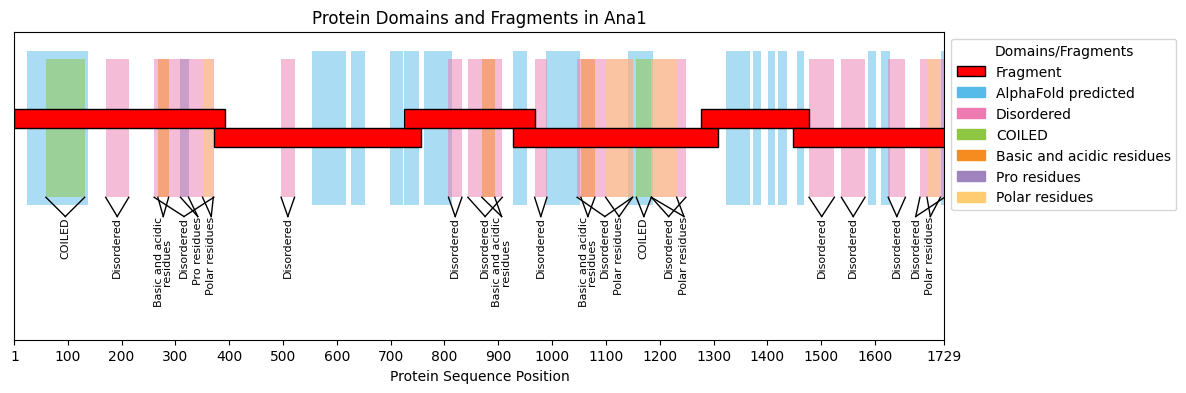

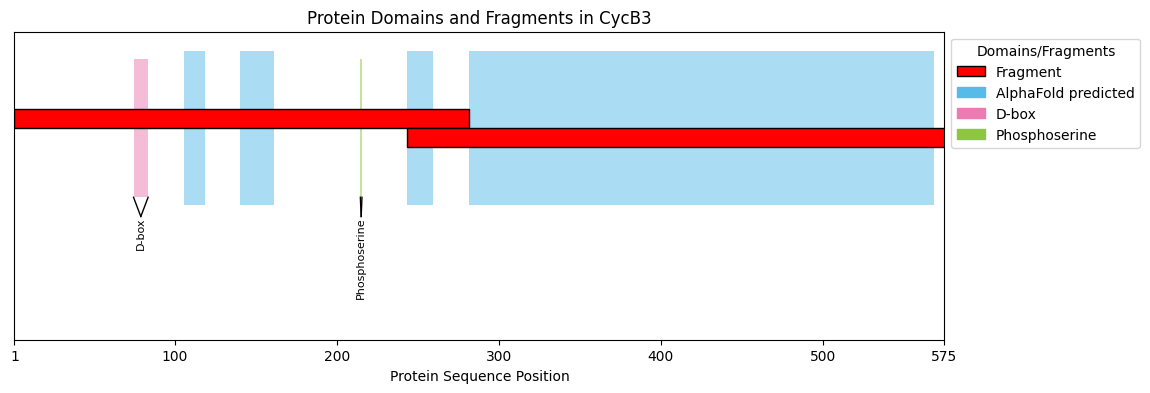

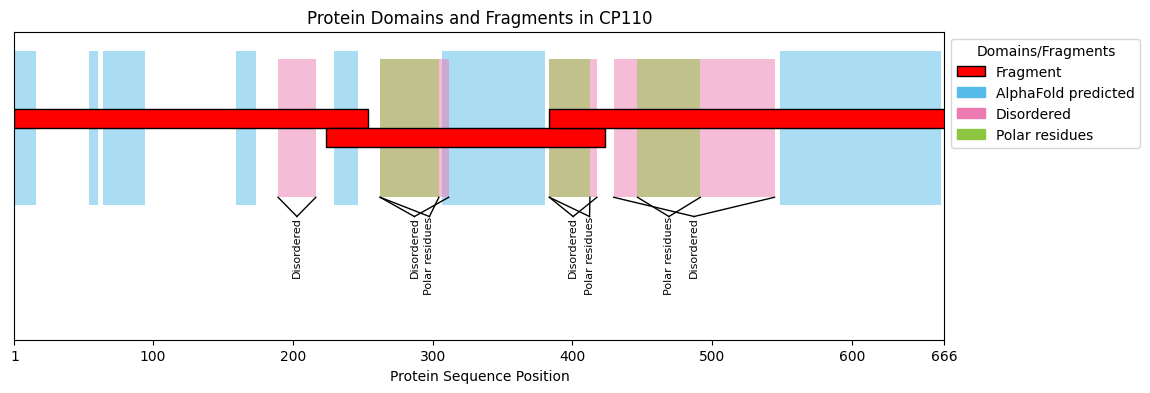

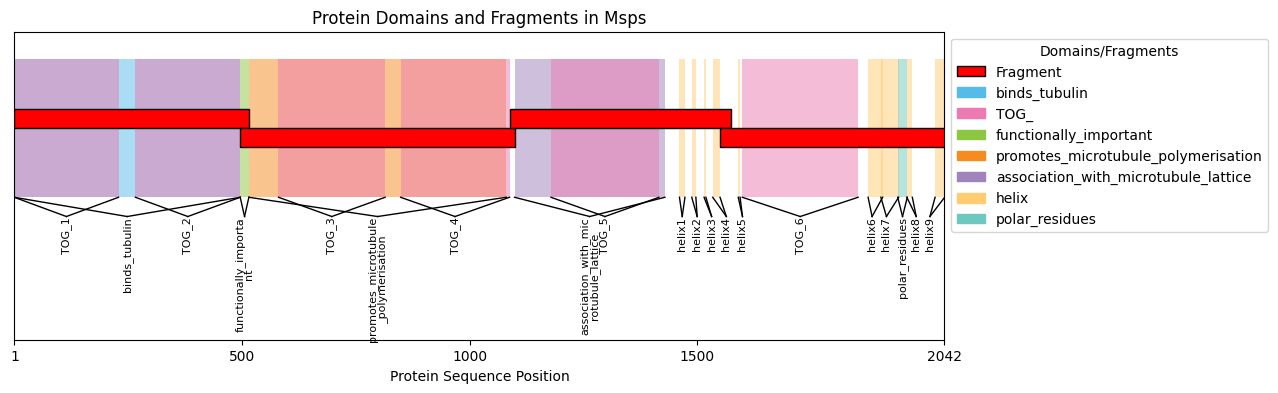

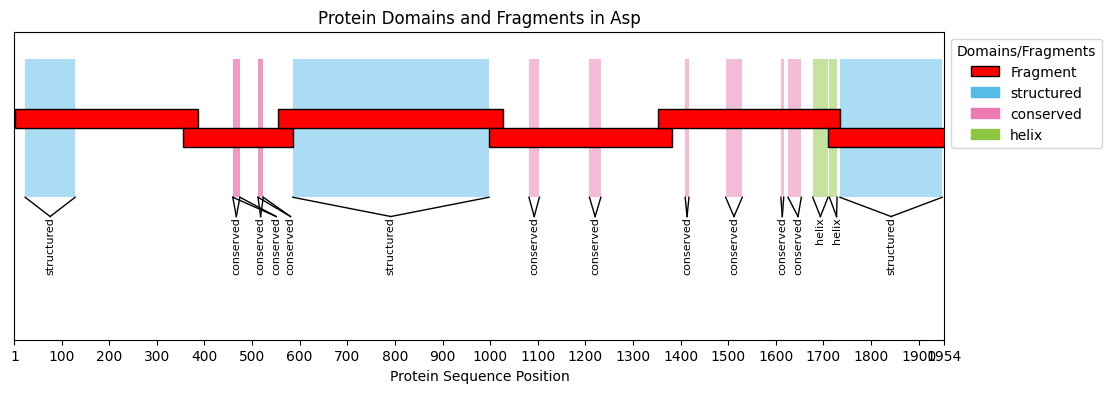

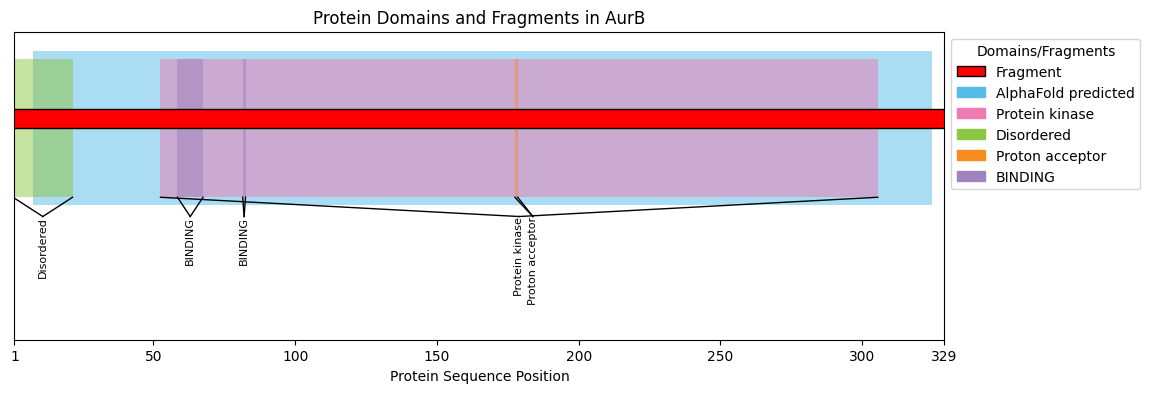

In [1]:
from alphafragment.process_proteins_csv import initialize_proteins_from_csv
from alphafragment.domain_compilation import compile_domains
from alphafragment.fragment_protein import fragment_protein
from alphafragment.plot_fragments import plot_fragmentation_output


input_csv_path = 'sample_data/usage_guide_sample2.csv'

# import protein data from a csv file into a list of Protein objects and a dataframe of all data in the csv
proteins, df = initialize_proteins_from_csv(input_csv_path)

for protein in proteins:
    # identify domains
    domains = compile_domains(protein, protein_data=df)
    # add domains to protein object
    for domain in domains:
        protein.add_domain(domain)

    # fragment the protein
    fragments = fragment_protein(protein)
    # add fragments to protein object
    for fragment in fragments:
        protein.add_fragment(fragment)

    # create graphic of domain locations and fragmentation results
    plot_fragmentation_output(protein, fragments)

If this is still insufficient to get the domains/fragments you want, there are other options.

Here is an example set of proteins with several special requirements:
- Some are standard proteins with just a name and uniprot id, for which we want to find domains from uniprot and the AFDB

- Some are proteins where original domain finding/fragmentation was unsatisfactory, as previously discussed. These have no uniprot id, and instead manually specified domains

- Some are proteins which are not available in uniprot/afdb, and so have no uniprot accession id and also no known domains to manually specify. For these you can run the full sequence in AlphaFold to create a pae file as would generally be found from the AFDB. The path to this csv file can be entered in the input csv in a column `PAE_file`. The function `domains_from_manual_pae` can then be used to find the domains from this pae.

- Some have a very specific desired fragmentation patterns, with fragment indices directly specified in a `fragments` column of the csv. Here we can use the function `fragments_from_csv` to read in and add these fragments to the protein object

In [ ]:
from alphafragment.fragment_protein import fragment_protein
from alphafragment.domain_compilation import compile_domains
from alphafragment.plot_fragments import plot_fragmentation_output
from alphafragment.process_proteins_csv import fragments_from_csv, domains_from_manual_pae

input_csv_path = 'sample_data/more_complex_proteins_example.csv'
proteins, df = initialize_proteins_from_csv(input_csv_path)

for protein in proteins:
    domains = []
    fragments = []
    fragments = fragments_from_csv(df, protein)
    if not fragments:
        domains = domains_from_manual_pae(df, protein)
        if not domains:
            domains = compile_domains(protein, protein_data=df)
        for domain in domains:
            protein.add_domain(domain)
        fragments = fragment_protein(protein)
    for fragment in fragments:
        protein.add_fragment(fragment)
    # remember to add a save location to this function if you want to save the images
    plot_fragmentation_output(protein, fragments, label=['UniProt', 'manually_defined'])

### Step 4: Recording domains and fragment locations in csv

To record domain and fragment locations for reference and future use, this can be saved to a CSV file. By including the dataframe read in from the original csv, all information from the original file will be retained, including other columns containing information about proteins not used here. Unlike those associated with the protein object which are intended for internal processing, the domin and fragment positions in the csv file will be 1 indexed.

In [ ]:
from alphafragment.process_proteins_csv import update_csv_with_fragments

output_csv_path = 'sample_usage_output.csv'
# update dataframe with protein information and save to csv
update_csv_with_fragments(df, output_csv_path, proteins)

### Step 5: Creating and outputting protein and domain pairs

Finally, once all proteins have been satisfactorily fragmented, the fragment pairs can be created. Depending on use case, different combinations of proteins can be generated:

![Screening Combinations](screening_combos4.svg)

To specify what combinations you want, use the `method` argument, with **'all'** for all v all (default), **'one'** for all v one, and **'specific'** for specific combinations. For **'one'**, use the `one_protein` argument to give the name of the target protein, and for `specific` use the combinations_csv argument to provide a csv with all the desired protein pairs. These should be formatted with 2 columns and one pair of proteins in each row, eg

|      |      |
|------|------|
| AurB | Msps |
| CycB3| CP110|
| CycB3| Msps |

A `save_location` can also be specified, as a folder path. The default for this is to save in the current working directory.

There are two format options for output - fasta or pulldown. The `output_fastas` function creates folders for each protein pair, each containing a fasta file for every domain pair between those proteins. Fasta files contain the sequences of the two protein fragments, and can be run in AlphaFold2/ColabFold.

The `output_pulldown` function saves a .txt and .fasta file in the format expected by the AlphaPulldown program.

In addition to the arguments described above, `output_fastas` also takes a save location, and `output_pulldown` names for the txt and fasta files.

In [ ]:
from alphafragment.fragment_file_creation import output_fastas, output_pulldown

# create fasta files with fragment combos
output_fastas(proteins)
# alternatively, create AlphaPulldown input file with fragment combos
output_pulldown(proteins)

### Adding extra proteins

If at a later point you want to expand your screen to include more proteins, without repeating predictions, please check out our follow up guide: [expanding the screen](expanding%20the%20screen%20guide.ipynb)